##### Copyright 2022 The TensorCircuit Authors.

# Barren plateaus

## Overview

Barren plateaus are the greatest difficulties in the gradient-based optimization for a large family of random parameterized quantum circuits (PQC). The gradients vanish almost everywhere. In this example, we will show barren plateaus in quantum neural networks (QNNs).

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import tensorcircuit as tc

tc.set_backend("tensorflow")
tc.set_dtype("complex128")
dtype = np.float64

## Parameters

In [2]:
n = [2 * i for i in range(2, 4, 1)]  # The number of qubits
nlayers = 10  # The number of circuit layers
nbatch = 5  # The number of random circuit instances

## Generating PQC

In [3]:
def generate_random_qnn(param, n, nlayers):
    c = tc.Circuit(n)
    for i in range(n):
        c.ry(i, theta=np.pi / 4)
    for l in range(nlayers):
        for i in range(n):
            random_n = np.random.uniform()
            if random_n > 2.0 / 3.0:
                c.rz(i, theta=param[l, i])
            elif random_n > 1.0 / 3.0:
                c.ry(i, theta=param[l, i])
            else:
                c.rx(i, theta=param[l, i])
        for i in range(n - 1):
            c.cz(i, i + 1)
    return c

## ZZ observable

In [4]:
def op_expectation(param, n, nlayers):
    c = generate_random_qnn(param, n, nlayers)
    e = 0.0
    e += c.expectation((tc.gates.z(), [0]), (tc.gates.z(), [1]))  # <Z_0Z_1>
    return tc.backend.real(e)

In [5]:
op_expectation_vvag = tc.backend.jit(
    tc.backend.vectorized_value_and_grad(op_expectation)
)  # use vvag to get the expectations of ZZ observable and gradients of different random circuit instances

## Batch variance computation

In [6]:
def process_batch(batch, n, nlayers, maxiter=1):
    param = tf.Variable(
        initial_value=tf.random.uniform(
            shape=[batch, nlayers, n], minval=0.0, maxval=2 * np.pi, dtype=dtype
        )
    )  # initial parameters

    opt = tf.keras.optimizers.Adam(1e-2)
    for i in range(maxiter):
        e, grad = op_expectation_vvag(param.value(), n, nlayers)  # energy and gradients
        opt.apply_gradients([(grad, param)])
    grad_var = tf.math.reduce_std(
        grad, axis=0
    )  # the variance of the gradient of the ZZ observable
    return (
        e,
        grad_var.numpy()[0, 0],
    )  # consider the variance of the gradient of the first parameter

In [7]:
grad_var_list = []
for i in n:
    e, grad_var = process_batch(nbatch, i, nlayers, 1)
    grad_var_list.append(grad_var)
print(grad_var_list)

2022-03-28 13:37:06.387892: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[0.13477102123244275, 0.1564351420584352]


## Results

The gradient variances in QNNs with $nlayers=50$ and $nbatch=200$. The landscape become exponentially barren with increasing qubit number. 

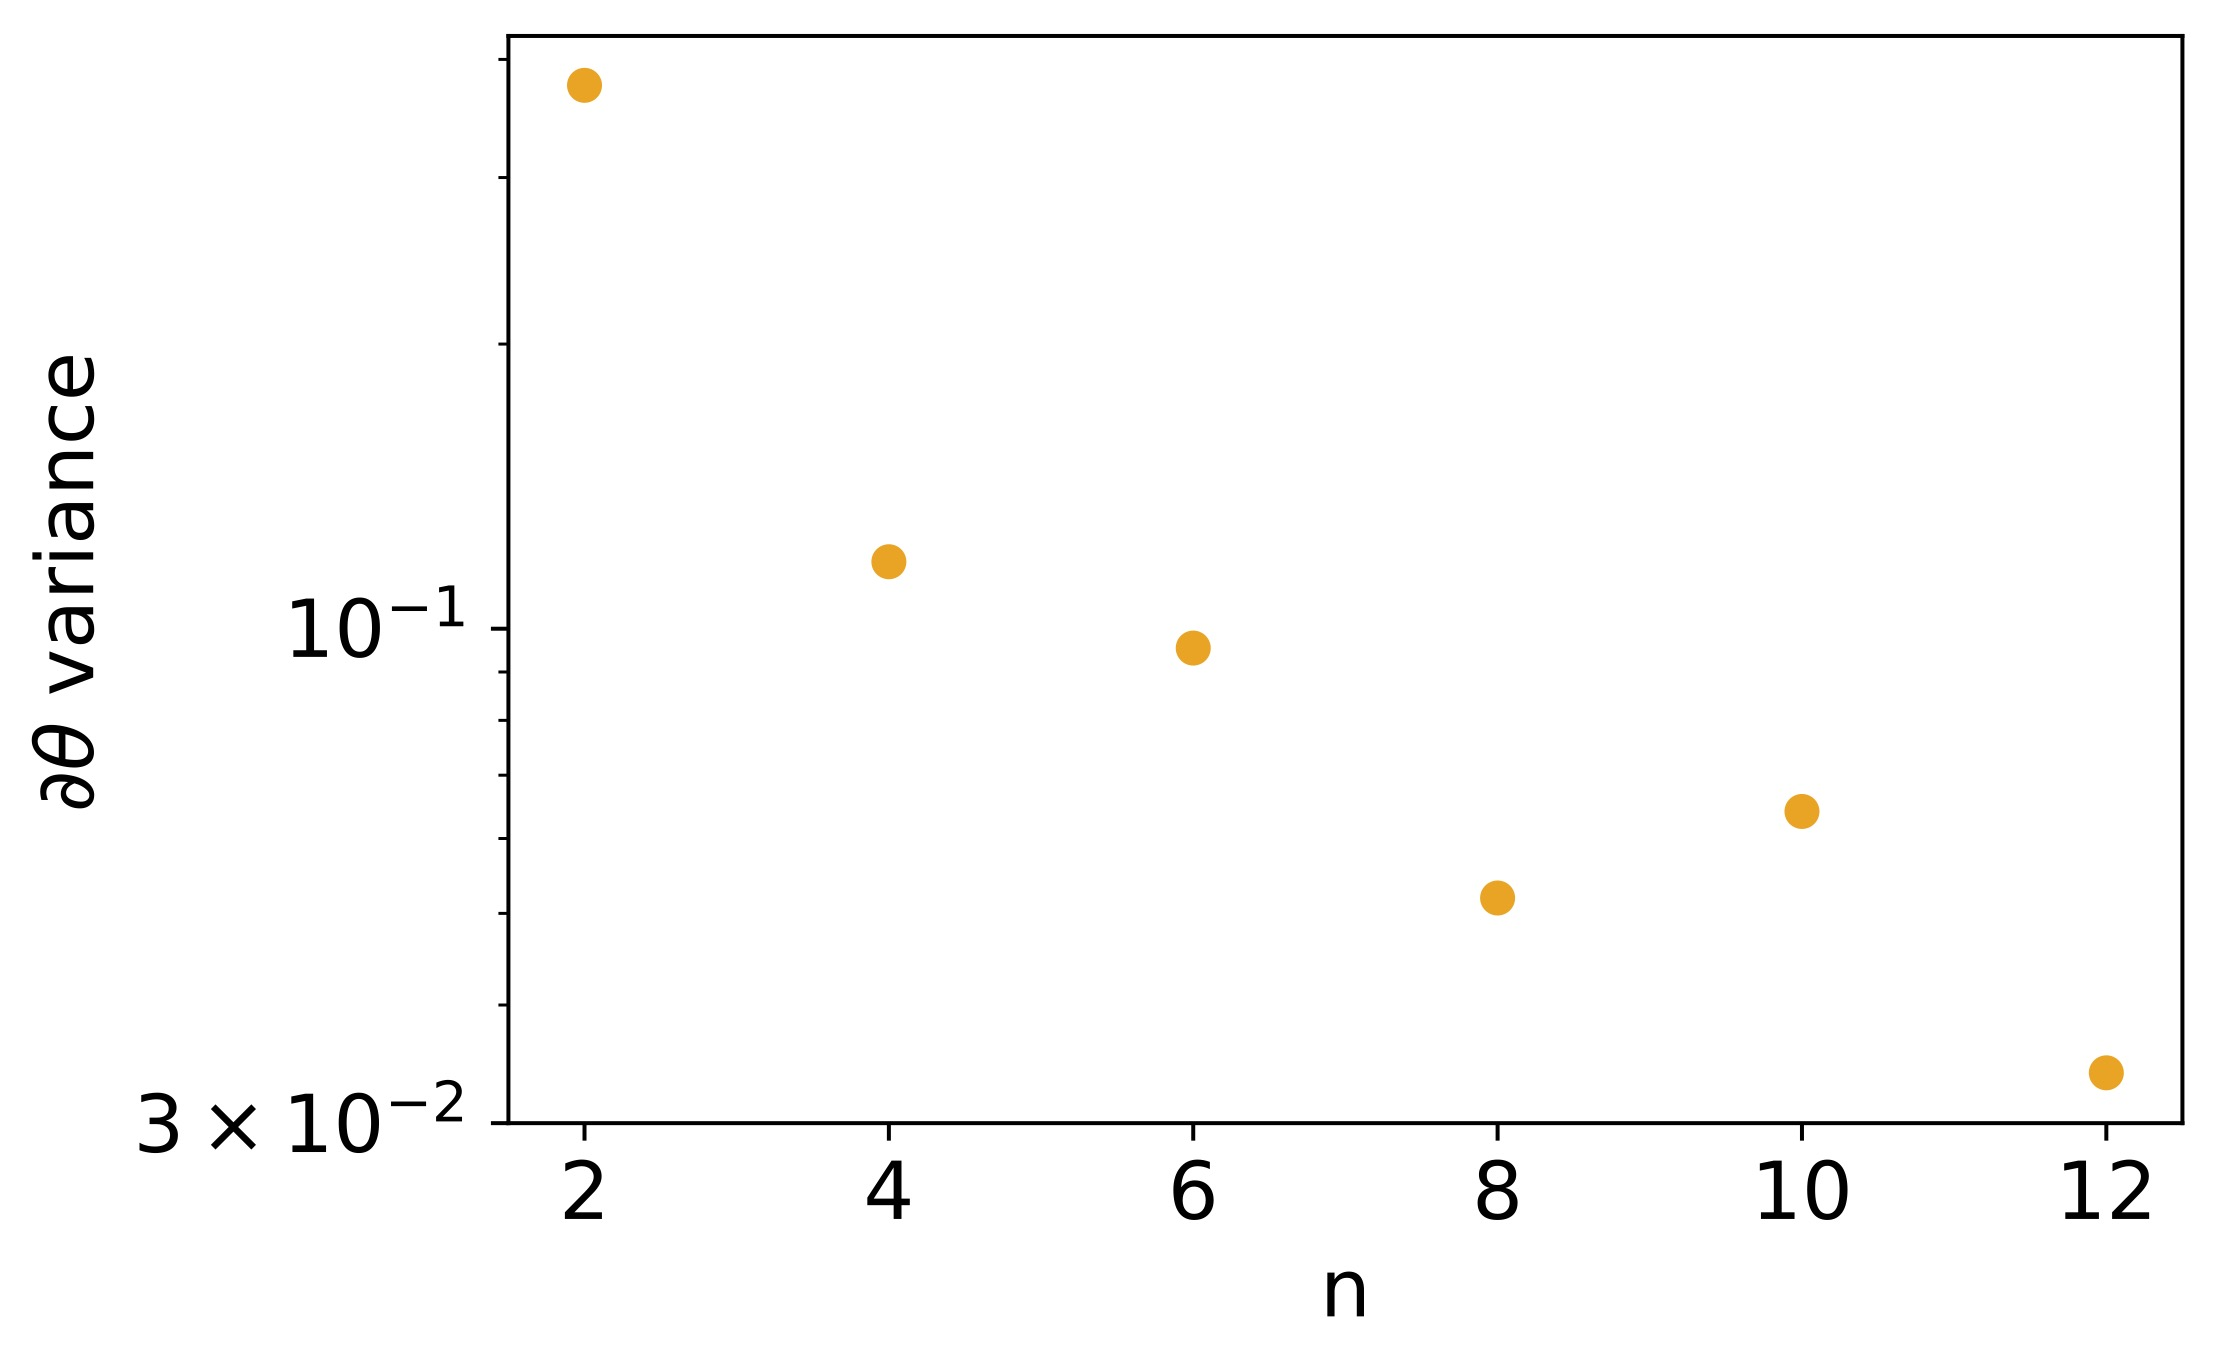